# Calorie Expenditure Prediction

## 1. Import data and libraries

In [18]:
# Import necessary libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import machine learning related libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_squared_log_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Import packages for model hyperparameter tuning
import optuna
from tqdm import tqdm

rmsle_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(
        mean_squared_log_error(y_true, np.maximum(y_pred, 0))
    ),
    greater_is_better=False
)

/Users/haeinpark/Projects/Data_Science_Projects/Calorie_Expenditure/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

if torch.cuda.is_available():
    print("CUDA 지원 GPU 사용 가능 ✔️")
    print("GPU 개수:", torch.cuda.device_count())
    print("현재 디바이스:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("GPU를 찾을 수 없습니다. CPU로 연산합니다.")

GPU를 찾을 수 없습니다. CPU로 연산합니다.


In [3]:
train_df = pd.read_csv('data/train.csv')

# 1. Basic Information about the dataset
print("=== Basic Dataset Information ===")
print(f"Dataset Shape: {train_df.shape}")
print("\nFirst few rows of the dataset:")
display(train_df.head())

=== Basic Dataset Information ===
Dataset Shape: (750000, 9)

First few rows of the dataset:


,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


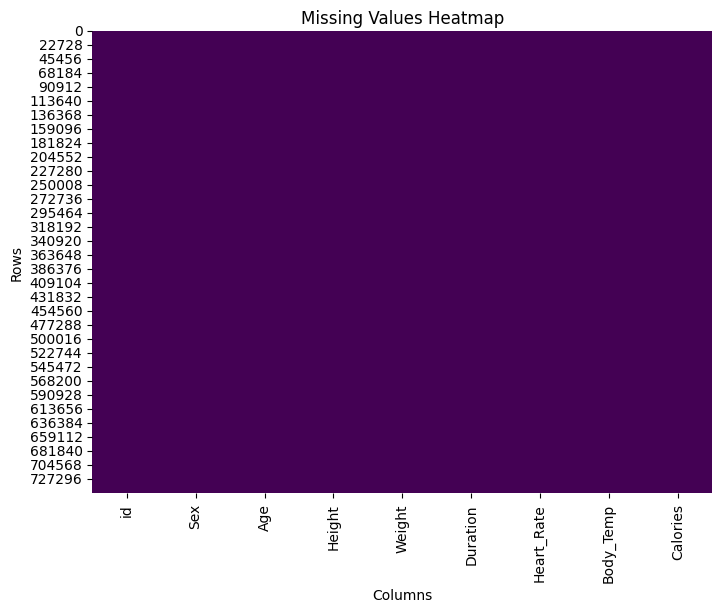

In [5]:
# 결측값 시각화 - No missing values.
plt.figure(figsize=(8, 6))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

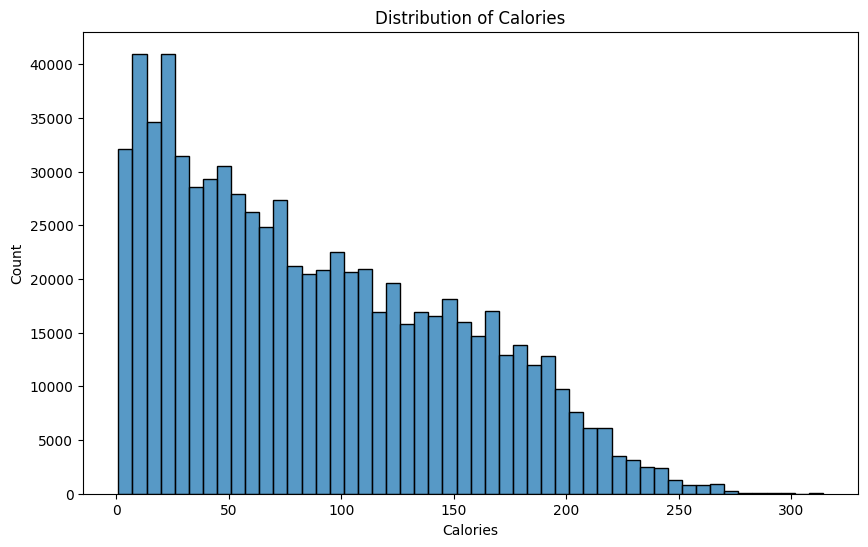

In [6]:
# 3. Distribution of target variable
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='Calories', bins=50)
plt.title('Distribution of Calories')
plt.xlabel('Calories')
plt.ylabel('Count')
plt.show()

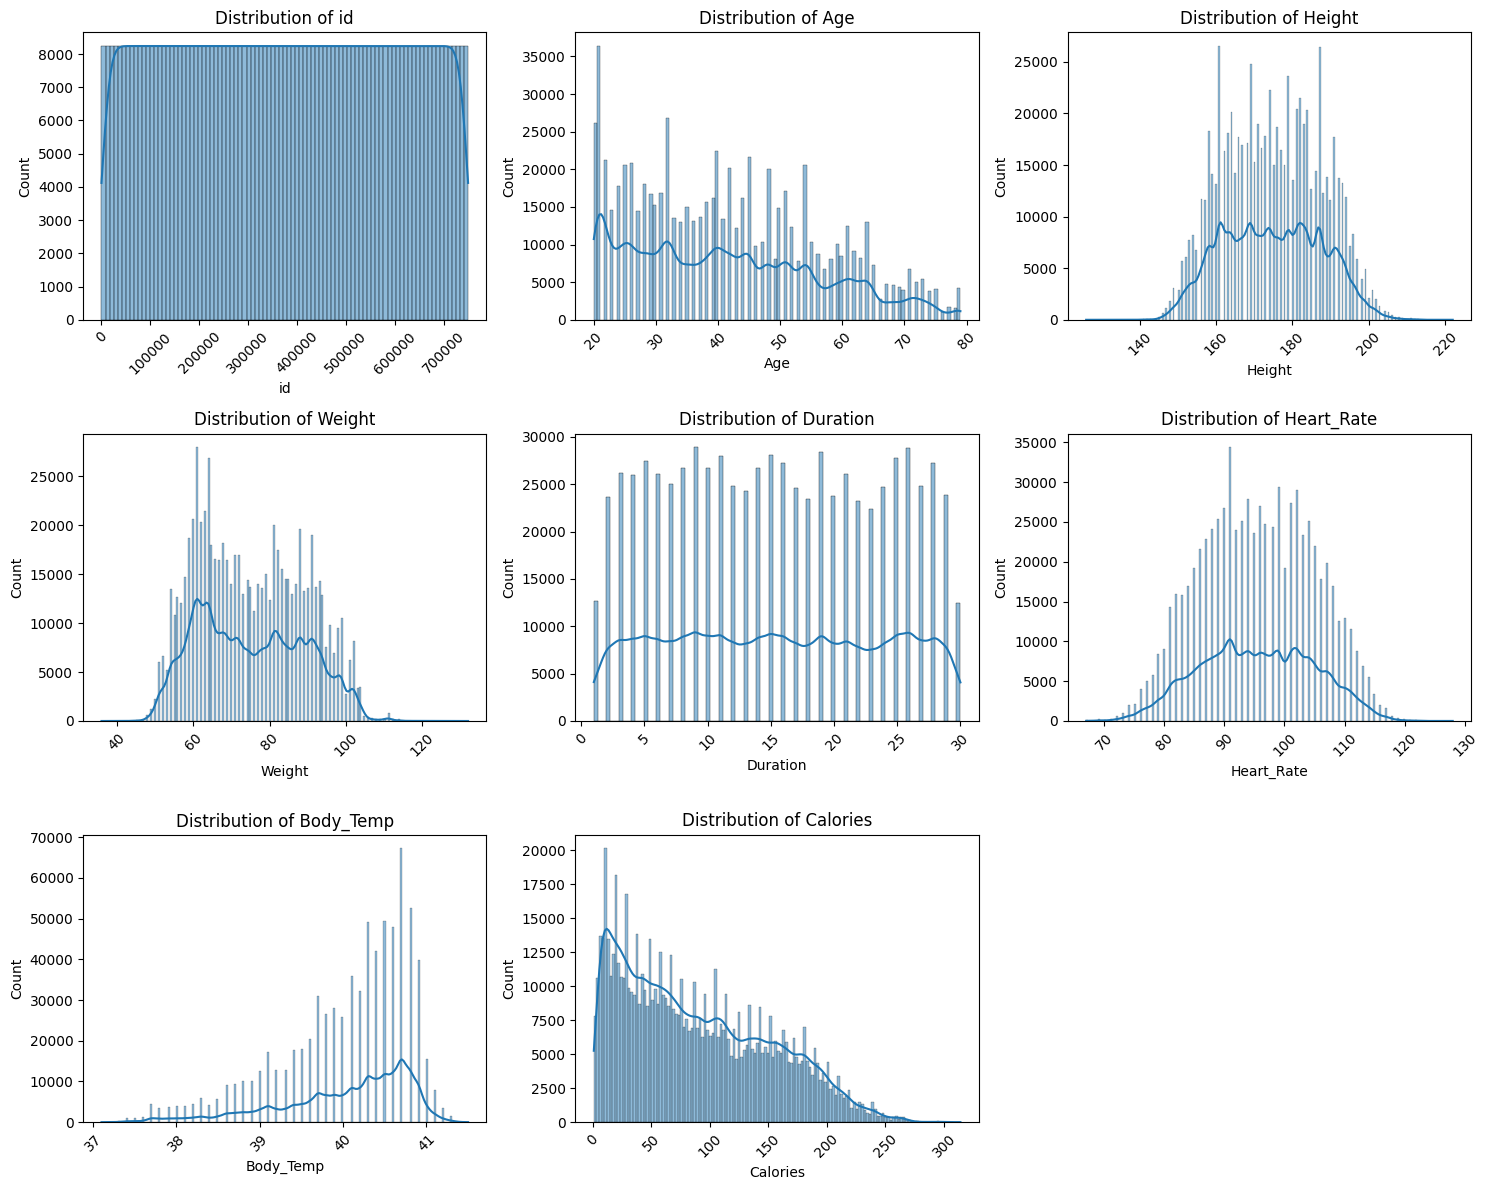


Basic Statistics for Numerical Features:


,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,216506.495284,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,0.000000,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,187499.750000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,374999.500000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,562499.250000,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,749999.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


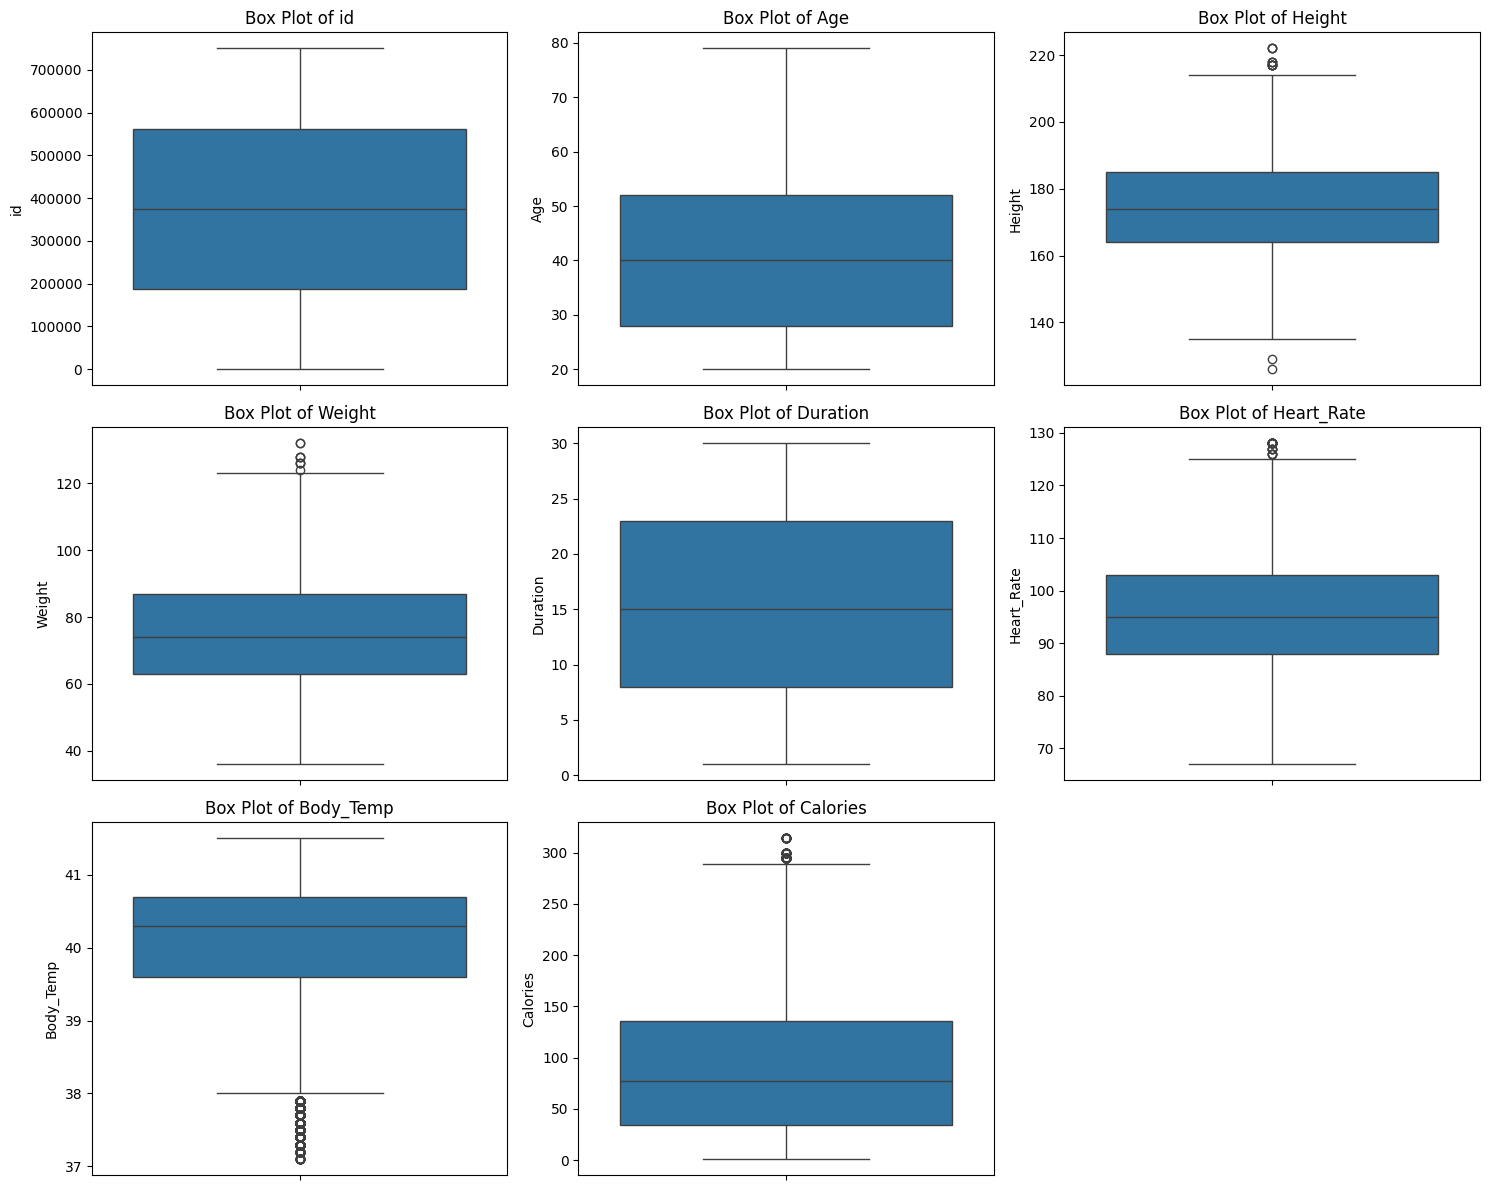

In [7]:
# Get all numerical columns
numerical_columns = train_df.select_dtypes(include=[np.number]).columns

# Calculate the number of rows and columns for subplots
n_cols = 3
n_rows = (len(numerical_columns) + n_cols - 1) // n_cols

# Create a figure with subplots
plt.figure(figsize=(15, 4*n_rows))

# Plot histograms for each numerical column
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(n_rows, n_cols, i)
    
    # Create histogram with KDE (Kernel Density Estimation)
    sns.histplot(data=train_df, x=column, kde=True)
    
    # Add title and labels
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    
    # Rotate x-axis labels if they're too long
    plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Print basic statistics for each numerical column
print("\nBasic Statistics for Numerical Features:")
display(train_df[numerical_columns].describe())

# Additional visualization: Box plots for each numerical feature
plt.figure(figsize=(15, 4*n_rows))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(y=train_df[column])
    plt.title(f'Box Plot of {column}')
    plt.ylabel(column)
plt.tight_layout()
plt.show()

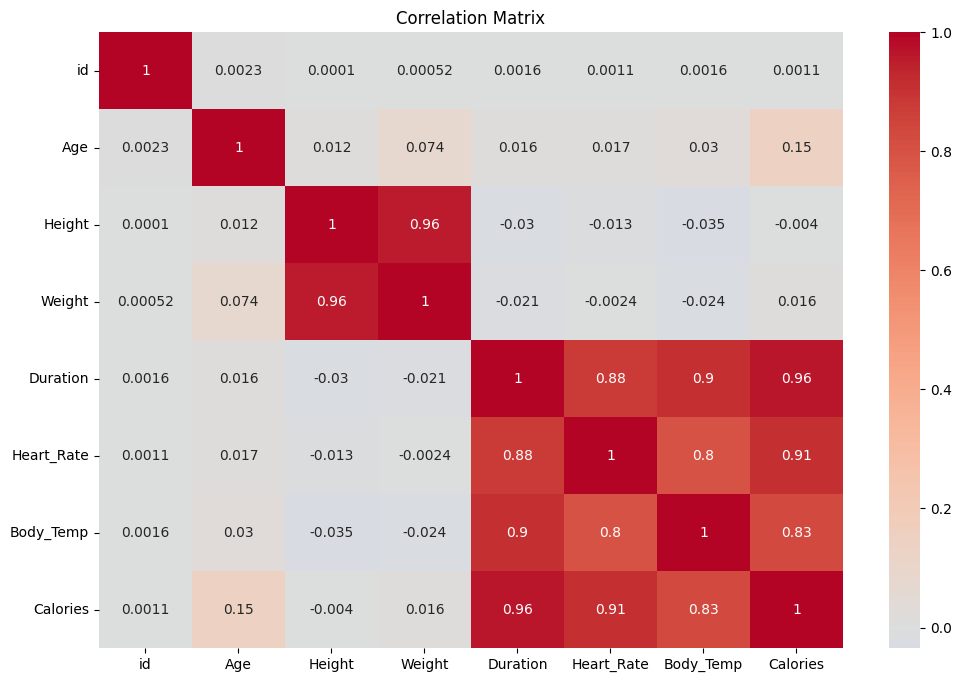

In [8]:
# 4. Correlation Analysis
numerical_df = train_df.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 8))
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

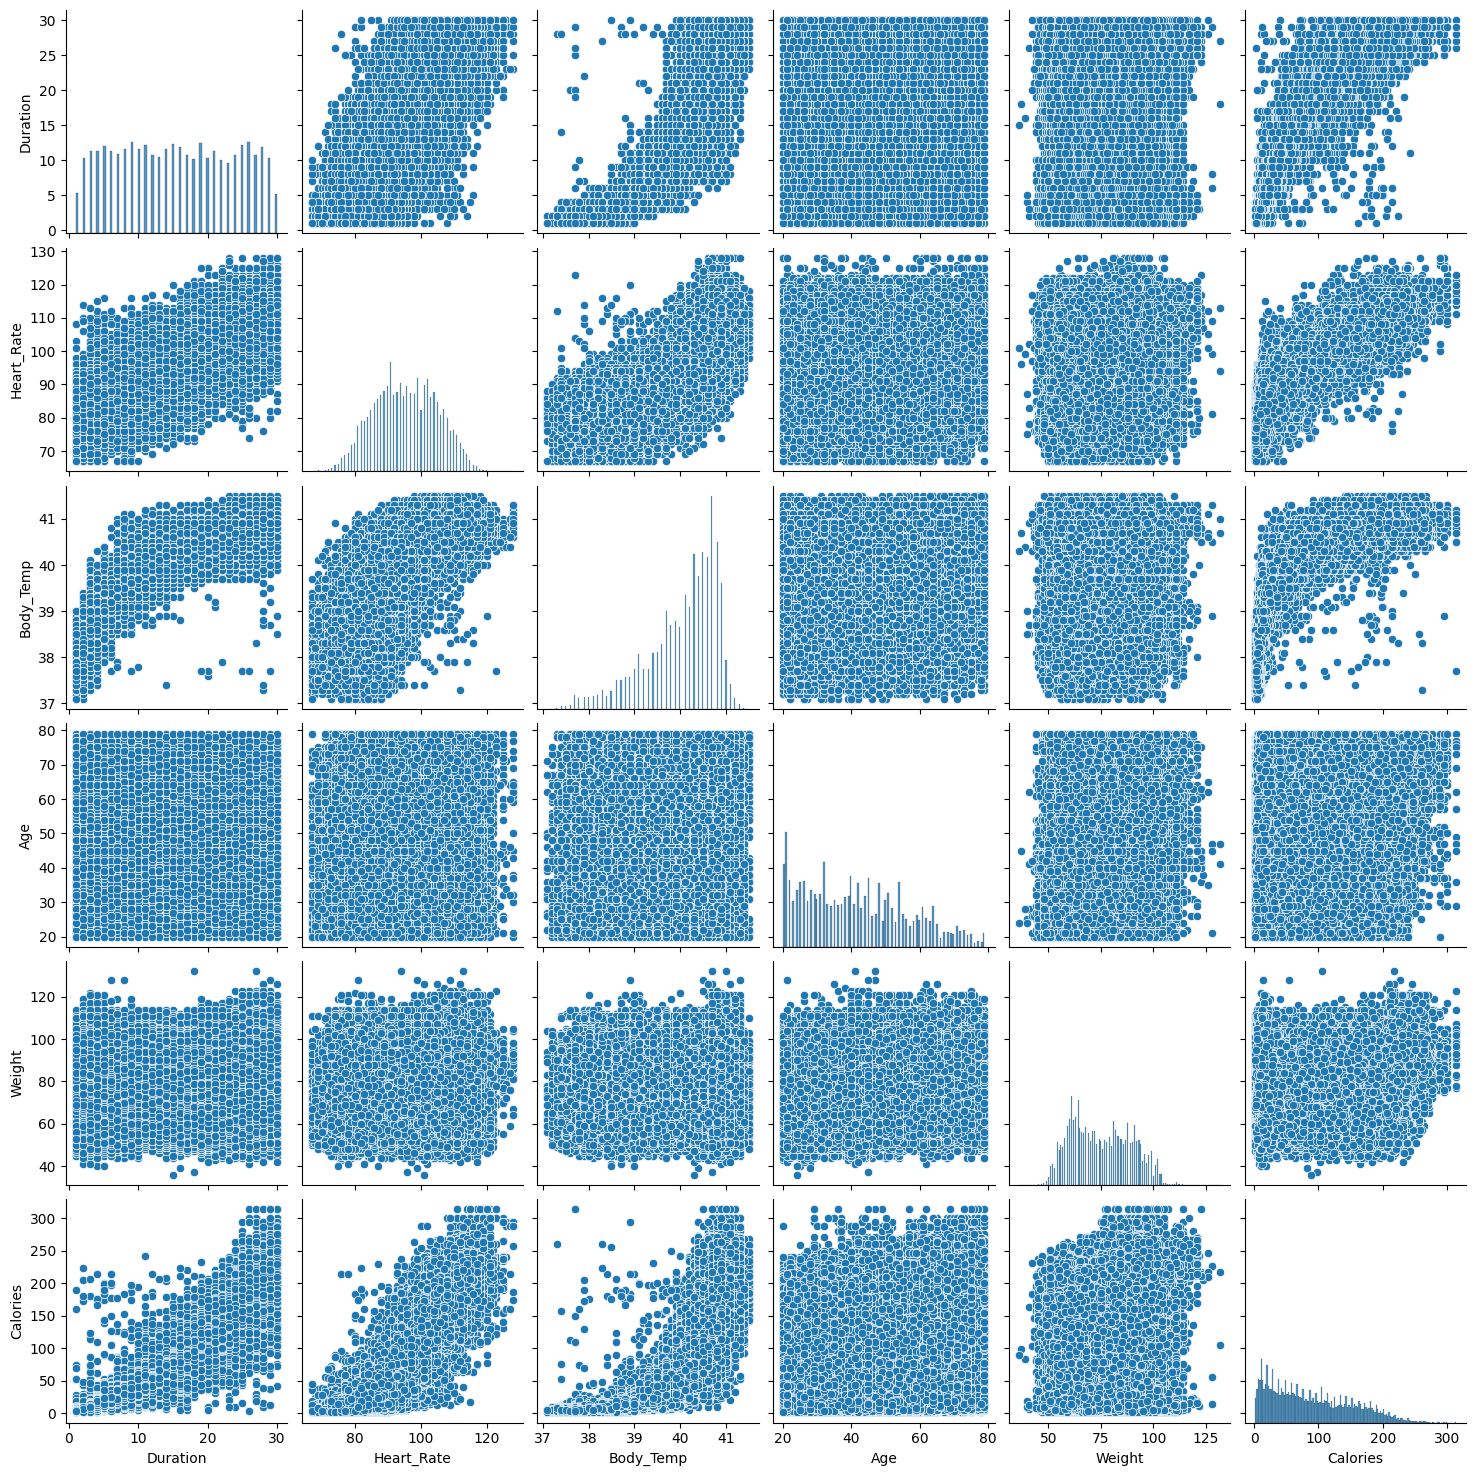

In [9]:
# 6. Pairplot for top correlated features with target
top_correlations = correlation_matrix['Calories'].sort_values(ascending=False)[1:6].index
sns.pairplot(train_df[list(top_correlations) + ['Calories']])
plt.show()


=== Categorical Variables Analysis ===

Value counts for Sex:


Sex
female    375721
male      374279
Name: count, dtype: int64

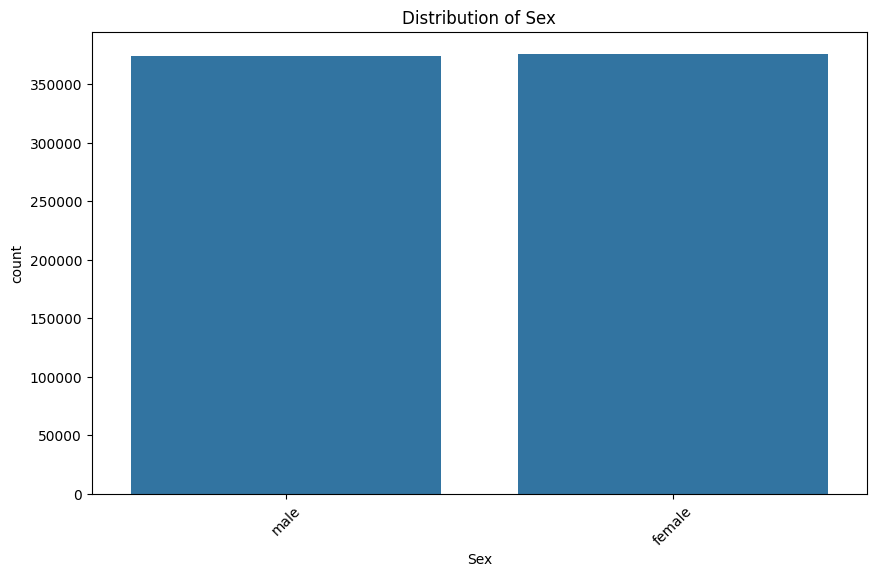

In [10]:
# 7. Summary statistics for categorical variables (if any)
categorical_columns = train_df.select_dtypes(include=['object']).columns
if len(categorical_columns) > 0:
    print("\n=== Categorical Variables Analysis ===")
    for column in categorical_columns:
        print(f"\nValue counts for {column}:")
        display(train_df[column].value_counts())
        
        plt.figure(figsize=(10, 6))
        sns.countplot(data=train_df, x=column)
        plt.title(f'Distribution of {column}')
        plt.xticks(rotation=45)
        plt.show()

## 2. Data Preprocessing!

* Removal of Outliers and Convert the categorical value

In [11]:
categorical_columns = train_df.select_dtypes(include=['object']).columns
numerical_columns = train_df.select_dtypes(include=[np.number]).columns
numerical_columns = numerical_columns.drop('id')

print(categorical_columns)
print(numerical_columns)

Index(['Sex'], dtype='object')
Index(['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp',
       'Calories'],
      dtype='object')


In [12]:
# Remove the outliers

def remove_outliers(df, columns):
    df_clean = df.copy()
    for column in columns:
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Print outlier information
        outliers = df_clean[(df_clean[column] < lower_bound) | (df_clean[column] > upper_bound)][column]
        print(f"\n{column}:")
        print(f"Number of outliers: {len(outliers)}")
        print(f"Percentage of outliers: {(len(outliers)/len(df_clean))*100:.2f}%")
        
        # Remove outliers
        df_clean = df_clean[(df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)]
    
    return df_clean

# Remove outliers from numerical columns
print("=== Outlier Removal Process ===")
train_df_clean = remove_outliers(train_df, numerical_columns)
print(f"\nOriginal dataset shape: {train_df.shape}")
print(f"Cleaned dataset shape: {train_df_clean.shape}")
print(f"Number of rows removed: {train_df.shape[0] - train_df_clean.shape[0]}")

=== Outlier Removal Process ===

Age:
Number of outliers: 0
Percentage of outliers: 0.00%

Height:
Number of outliers: 14
Percentage of outliers: 0.00%

Weight:
Number of outliers: 4
Percentage of outliers: 0.00%

Duration:
Number of outliers: 0
Percentage of outliers: 0.00%

Heart_Rate:
Number of outliers: 36
Percentage of outliers: 0.00%

Body_Temp:
Number of outliers: 14919
Percentage of outliers: 1.99%

Calories:
Number of outliers: 141
Percentage of outliers: 0.02%

Original dataset shape: (750000, 9)
Cleaned dataset shape: (734886, 9)
Number of rows removed: 15114


In [13]:
train_df_clean.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [14]:
# 'Calories'와 'id'를 제외한 X, y 분리
X = train_df_clean.drop(['Calories', 'id'], axis=1)
y = train_df_clean['Calories']

# 2. 최초 분할: 80% 훈련, 20% 홀드‑아웃 테스트
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# 수치형·범주형 컬럼 자동 구분
numerical_columns = X_train.select_dtypes(include=[np.number]).columns
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns


# 전처리기 정의
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_columns)
    ],
    remainder='drop'
)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# 파이프라인에 전처리기와 모델을 순차 연결
pipelines = {
    'LinearRegression': Pipeline([
        ('preproc', preprocessor),
        ('model',   LinearRegression())
    ]),
    'RandomForest': Pipeline([
        ('preproc', preprocessor),
        ('model',   RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42))
    ]),
    'GradientBoosting': Pipeline([
        ('preproc', preprocessor),
        ('model',   GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('preproc', preprocessor),
        ('model', XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, verbosity=0))
    ])
}

# 6. 5-겹 CV 설정 및 지표 정의
cv_folds = 5
scoring = {
    'RMSE': 'neg_root_mean_squared_error',
    'MAE':  'neg_mean_absolute_error',
    'R2':   'r2',
    'RMSLE': rmsle_scorer
}

# 7. 훈련 세트(X_train, y_train)로만 CV 실행
cv_results = {}
for name, pipe in pipelines.items():
    res = cross_validate(pipe,
                         X_train, y_train,
                         cv=cv_folds,
                         scoring=scoring,
                         return_train_score=False,
                         n_jobs=-1)
    cv_results[name] = {
        'RMSE': np.mean(-res['test_RMSE']),   # 부호 반전
        'MAE':  np.mean(-res['test_MAE']),
        'R2':   np.mean( res['test_R2'] ),
        'RMSLE': np.mean(-res['test_RMSLE'])
    }
    print(f"{name}: RMSE={cv_results[name]['RMSE']:.3f}, "
          f"MAE={cv_results[name]['MAE']:.3f}, "
          f"R²={cv_results[name]['R2']:.3f}, "
          f"RMSLE={cv_results[name]['RMSLE']:.3f}")

LinearRegression: RMSE=10.992, MAE=8.047, R²=0.968, RMSLE=0.548
RandomForest: RMSE=4.943, MAE=3.261, R²=0.994, RMSLE=0.076
GradientBoosting: RMSE=4.658, MAE=3.092, R²=0.994, RMSLE=0.104
XGBoost: RMSE=3.737, MAE=2.322, R²=0.996, RMSLE=0.061


In [16]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_log_error

# 8. XGBoost 가장 우수
best_model = pipelines['XGBoost']

# 9. 전체 훈련 세트에 재학습
best_model.fit(X_train, y_train)

# 10. 홀드‑아웃 세트 예측
y_pred = best_model.predict(X_test)

# 11. 성능 계산
rmse_final = root_mean_squared_error(y_test, y_pred)
mae_final  = mean_absolute_error(y_test, y_pred)
r2_final   = r2_score(y_test, y_pred)
rmsle_final = root_mean_squared_log_error(y_test, np.maximum(y_pred, 0))

print("\nFinal Hold-Out Results:")
print(f"RMSE: {rmse_final:.3f}")
print(f"MAE:  {mae_final:.3f}")
print(f"R²:   {r2_final:.3f}")
print(f"RMSLE: {rmsle_final:.3f}")


Final Hold-Out Results:
RMSE: 3.736
MAE:  2.326
R²:   0.996
RMSLE: 0.061


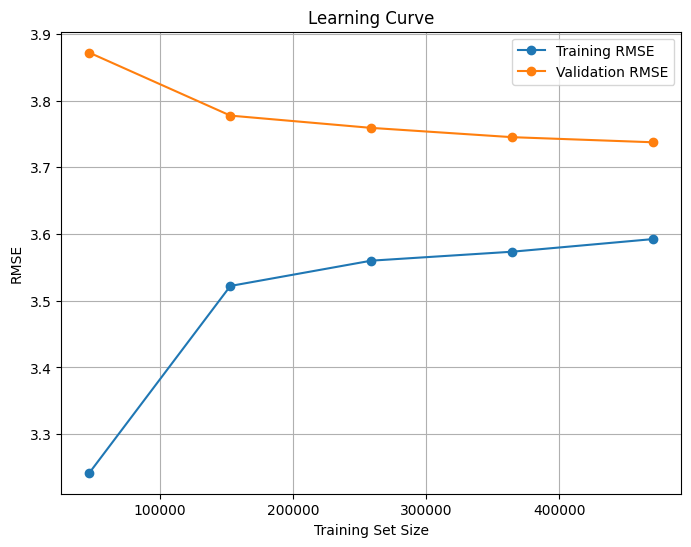

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# 1) 학습 곡선 데이터를 계산합니다.
#    train_sizes: 사용할 훈련 데이터 비율(또는 절대 수)
#    train_scores/test_scores: 각 크기별 교차검증 훈련/검증 점수 (여기서는 neg RMSE)
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,                  # 최종 선택된 모델 객체
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 5),  # 10%, 32.5%, 55%, 77.5%, 100%
    cv=5,                                  # 5-겹 교차검증
    scoring='neg_root_mean_squared_error', # RMSE 기준 (음수로 반환)  [oai_citation:0‡Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html?utm_source=chatgpt.com)
    n_jobs=-1
)

# 2) 점수를 양수 RMSE로 변환하고 평균을 낸 뒤 플롯
train_rmse = -np.mean(train_scores, axis=1)
val_rmse   = -np.mean(test_scores,  axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_rmse, marker='o', label='Training RMSE')
plt.plot(train_sizes, val_rmse,   marker='o', label='Validation RMSE')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.title('Learning Curve')                        # 학습 곡선 시각화  [oai_citation:1‡Scikit-learn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html?utm_source=chatgpt.com)
plt.legend()
plt.grid(True)
plt.show()

/Users/haeinpark/Projects/Data_Science_Projects/Calorie_Expenditure/venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


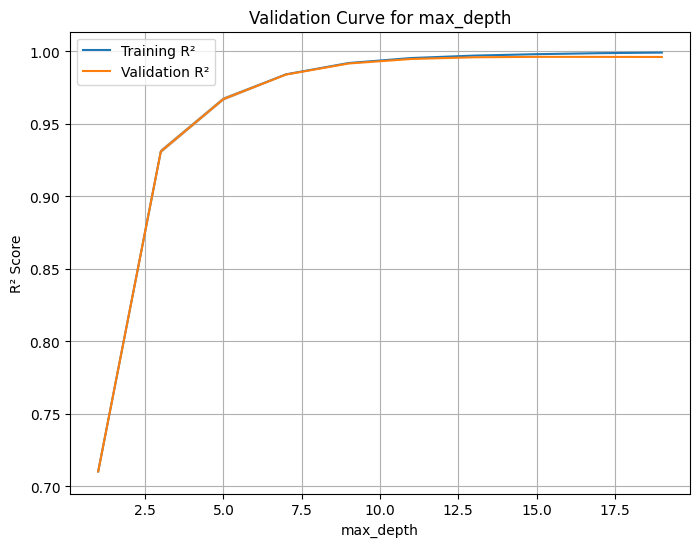

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

# 예: RandomForest의 max_depth 파라미터 변화에 따른 검증 곡선
param_name  = 'model__max_depth'             # Pipeline 안의 RandomForest max_depth
param_range = np.arange(1, 21, 2)            # 1,3,5,...,19

train_scores, test_scores = validation_curve(
    estimator=best_model,                    # Pipeline 전체 혹은 모델 객체
    X=X_train,
    y=y_train,
    param_name=param_name,                   # 하이퍼파라미터 이름  [oai_citation:2‡Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html?utm_source=chatgpt.com)
    param_range=param_range,
    cv=5,
    scoring='r2',                            # R² 기준
    n_jobs=-1
)

# 평균과 표준편차 계산
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores,  axis=1)
val_mean   = np.mean(test_scores,  axis=1)
val_std    = np.std(test_scores,   axis=1)

plt.figure(figsize=(8,6))
plt.plot(param_range, train_mean, label='Training R²')
plt.fill_between(param_range, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.plot(param_range, val_mean,    label='Validation R²')
plt.fill_between(param_range, val_mean-val_std,   val_mean+val_std,   alpha=0.2)
plt.xlabel('max_depth')
plt.ylabel('R² Score')
plt.title('Validation Curve for max_depth')       # 검증 곡선 시각화  [oai_citation:3‡Scikit-learn](https://scikit-learn.org/stable/modules/learning_curve.html?utm_source=chatgpt.com)
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Hyperparameter tunning for XGBoost

def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }
    
    model = XGBRegressor(**params, early_stopping_rounds=20, random_state=42)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    preds = model.predict(X_test)
    rmse =root_mean_squared_error(y_test, preds)
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Best trial:")
print(f"Value: {study.best_trial.value}")
print("Params:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

[I 2025-05-10 01:31:13,805] A new study created in memory with name: no-name-eeccfcf5-2cdc-4458-a03b-17b6ef48dead
  0%|          | 0/50 [00:00<?, ?it/s]


[W 2025-05-10 01:31:13,812] Trial 0 failed with parameters: {'n_estimators': 619, 'max_depth': 8, 'learning_rate': 0.04370345620915783, 'subsample': 0.7133962708336044, 'colsample_bytree': 0.8138417890001475, 'gamma': 1.308529108504306, 'min_child_weight': 6} because of the following error: ValueError('DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Sex: object').
Traceback (most recent call last):
  File "/Users/haeinpark/Projects/Data_Science_Projects/Calorie_Expenditure/venv/lib/python3.12/site-packages/xgboost/data.py", line 407, in pandas_feature_info
    new_feature_types.append(_pandas_dtype_mapper[dtype.name])
                             ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'object'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/haeinpark/Projects/Data_Sci

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Sex: object